# VQ-VAE

This notebook is a PyTorch port of the the [Keras](https://keras.io/examples/generative/vq_vae/) implementation of VQ-VAE (with some tweaks). Additionally this [PyTorch](https://github.com/zalandoresearch/pytorch-vq-vae) implementation was consulted during the implementation process.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms as T, datasets

In [2]:
# Training parameters
assert torch.cuda.is_available()
DEVICE = torch.device("cuda:0")

NUM_EPOCHS=100 
BATCH_SIZE=128
LATENT_DIM=16
NUM_EMBEDDINGS=128

In [3]:
class VectorQuantizer(nn.Module):
    
    def __init__(self, num_embeddings, embedding_dim, beta=0.25):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        # commitment loss scalar
        self.beta = beta
        
        # creating an embedding table
        embedding_weights = torch.rand(size=(num_embeddings, embedding_dim), 
                                       requires_grad=True,
                                       device=DEVICE)
        self.embeddings = nn.Parameter(embedding_weights)
    
    def forward(self, x):        
        # we need to reshape the input from N, C, H, W to N, H, W, C
        transposed = x.permute(0, 2, 3, 1).contiguous()
        
        flattened = transposed.view(-1, self.embedding_dim)
        
        encoding_indices = self.get_code_indices(flattened)
        encodings = torch.nn.functional.one_hot(encoding_indices, num_classes=self.num_embeddings).to(torch.float32)
        quantized = encodings @ self.embeddings
        quantized = quantized.view(transposed.shape)
        
        # loss calculation
        commitment_loss = torch.mean((quantized.detach() - transposed) ** 2)
        codebook_loss = torch.mean((quantized - transposed.detach()) ** 2)
        
        quantized = transposed + (quantized - transposed).detach()
        
        return quantized.permute(0, 3, 1, 2).contiguous(), codebook_loss, commitment_loss

    def get_code_indices(self, flattened):
        similarity = torch.matmul(flattened, self.embeddings.T)
        distances = (
            torch.sum(flattened ** 2, dim=1, keepdims=True)
            + torch.sum(self.embeddings ** 2)
            - 2 * similarity
        )
        
        encoding_indices = torch.argmin(distances, dim=1)
        return encoding_indices


In [4]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=latent_dim, kernel_size=1),
        )
    
    def forward(self, x):
        return self.layers(x)

In [5]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(in_channels=latent_dim, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

In [6]:
class VQ_VAE(nn.Module):
    def __init__(self, latent_dim=16, num_embeddings=64):
        super().__init__()
        self.vq = VectorQuantizer(num_embeddings, latent_dim)
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        
    def forward(self, x):
        inp = x
        x = self.encoder(x)
        x, codebook_loss, commitment_loss = self.vq(x)
        x = self.decoder(x)
        reconstruction_loss = nn.functional.mse_loss(x, inp)
        return x, reconstruction_loss, codebook_loss, commitment_loss
    
    def get_encoder(self):
        return self.encoder
    
    def get_decoder(self):
        return self.decoder
    
    def get_vq(self):
        return self.vq

In [7]:
train_dataset = datasets.MNIST(root="../datasets/", train=True, transform=T.ToTensor(), download=True)
test_dataset = datasets.MNIST(root="../datasets/", train=False, transform=T.ToTensor(), download=False)

In [8]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
train_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=False)

In [9]:
model = VQ_VAE(LATENT_DIM, NUM_EMBEDDINGS)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [10]:
def train(num_epochs, train_dataloader, model, optimizer, beta=0.25):
    history = {"reconstruction_loss": [], "codebook_loss": [], "commitment_loss": [], "full_loss": []}
    model.to(DEVICE)
    for epoch in range(num_epochs):
        num_batches = 0
        history["reconstruction_loss"] = []
        history["codebook_loss"] = []
        history["commitment_loss"] = []
        history["full_loss"] = []

        
        for batch_idx, (features, _) in enumerate(train_dataloader):
            model.train()
            num_batches+=1
            
            features = features.to(DEVICE)
            
            # Forward Pass and Loss
            _, reconstruction_loss, codebook_loss, commitment_loss = model(features)
            loss = reconstruction_loss + codebook_loss + commitment_loss*beta
            
            history["reconstruction_loss"].append(reconstruction_loss.cpu().item())
            history["codebook_loss"].append(codebook_loss.cpu().item())
            history["commitment_loss"].append(commitment_loss.cpu().item())
            history["full_loss"].append(loss.cpu().item())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        reconstruction_loss, codebook_loss, commitment_loss, full_loss = sum(history["reconstruction_loss"])/num_batches, \
                                                                         sum(history["codebook_loss"])/num_batches, \
                                                                         sum(history["commitment_loss"])/num_batches, \
                                                                         sum(history["full_loss"])/num_batches

        if epoch % 10 == 0:
            print(f'Epoch: {epoch+1:>2}/{num_epochs} | Reconstruction Loss: {reconstruction_loss:.5f} | Codebook Loss: {codebook_loss:.5f} | Commitment Loss: {commitment_loss:.5f} | Full Loss: {full_loss:.5f}')
        

In [11]:
train(NUM_EPOCHS, train_dataloader, model, optimizer)

Epoch:  1/100 | Reconstruction Loss: 0.12412 | Codebook Loss: 0.25247 | Commitment Loss: 0.25247 | Full Loss: 0.43970
Epoch: 11/100 | Reconstruction Loss: 0.03749 | Codebook Loss: 0.13655 | Commitment Loss: 0.13655 | Full Loss: 0.20818
Epoch: 21/100 | Reconstruction Loss: 0.02951 | Codebook Loss: 0.19910 | Commitment Loss: 0.19910 | Full Loss: 0.27838
Epoch: 31/100 | Reconstruction Loss: 0.02795 | Codebook Loss: 0.20528 | Commitment Loss: 0.20528 | Full Loss: 0.28455
Epoch: 41/100 | Reconstruction Loss: 0.02631 | Codebook Loss: 0.19273 | Commitment Loss: 0.19273 | Full Loss: 0.26721
Epoch: 51/100 | Reconstruction Loss: 0.02474 | Codebook Loss: 0.18150 | Commitment Loss: 0.18150 | Full Loss: 0.25162
Epoch: 61/100 | Reconstruction Loss: 0.02332 | Codebook Loss: 0.15205 | Commitment Loss: 0.15205 | Full Loss: 0.21339
Epoch: 71/100 | Reconstruction Loss: 0.02131 | Codebook Loss: 0.10877 | Commitment Loss: 0.10877 | Full Loss: 0.15728
Epoch: 81/100 | Reconstruction Loss: 0.02190 | Codebook 

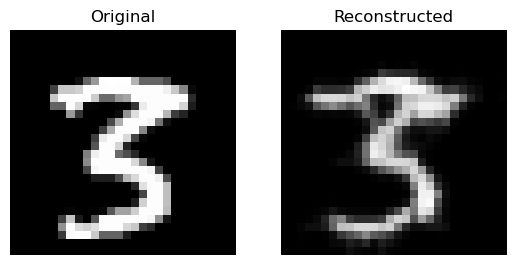

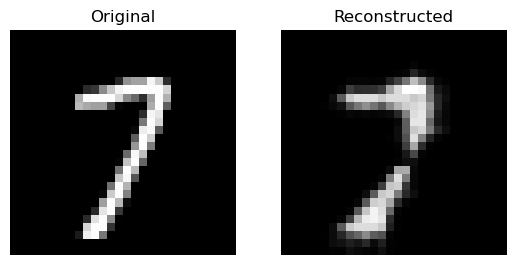

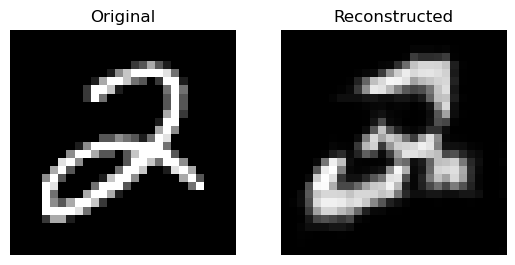

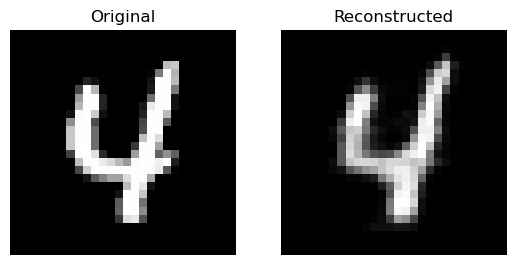

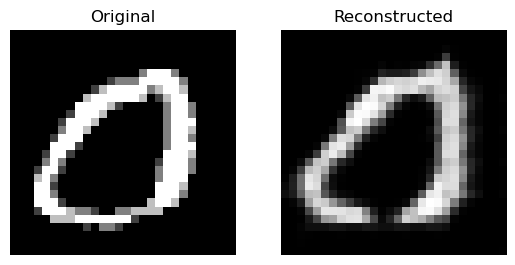

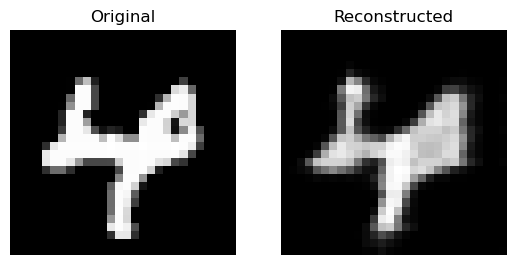

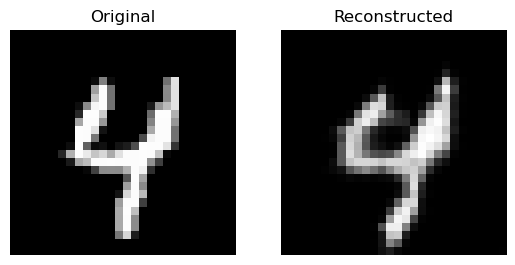

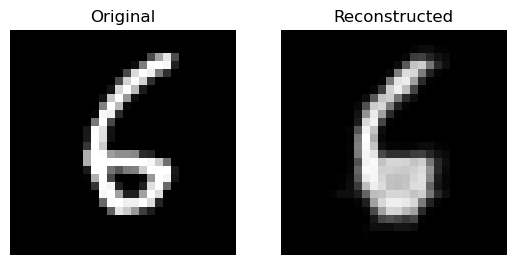

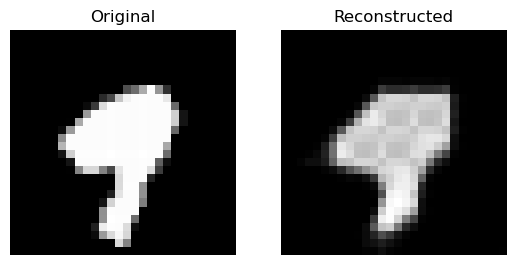

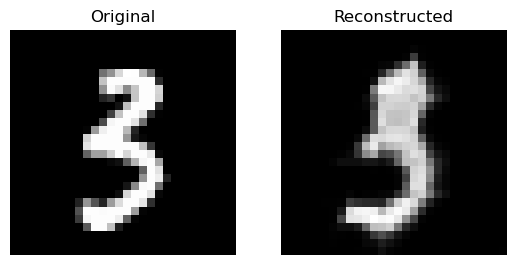

In [12]:
def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap="gray")
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed, cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()

with torch.inference_mode():
    idx = np.random.choice(len(test_dataset), 10)
    for i in idx:
        image, _ = test_dataset[i]
        image = image.unsqueeze(0)
        reconstruction, *rest = model(image.to(DEVICE))
        image = image.squeeze().to('cpu').numpy()
        reconstruction = reconstruction.squeeze().to('cpu').numpy()
        show_subplot(image, reconstruction)


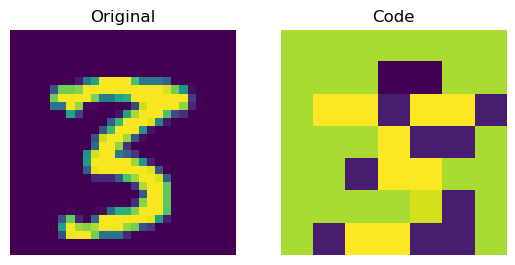

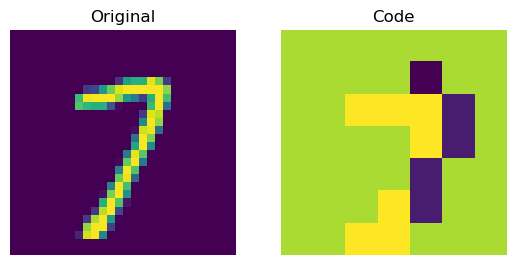

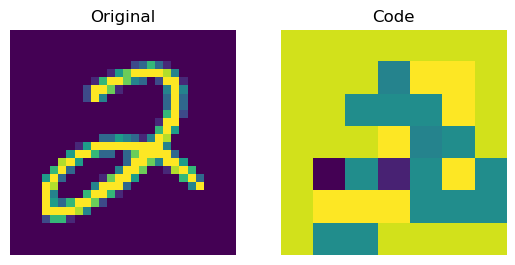

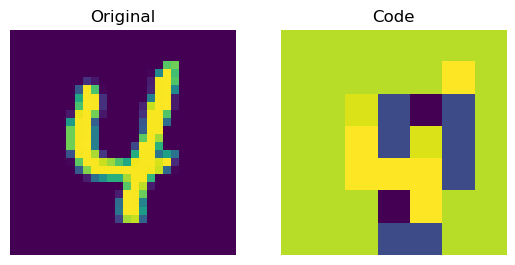

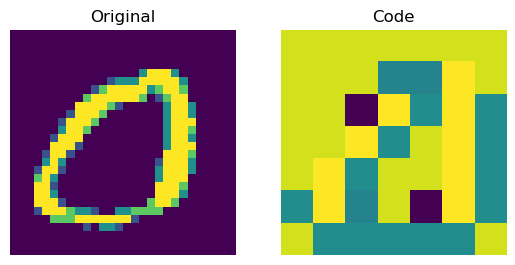

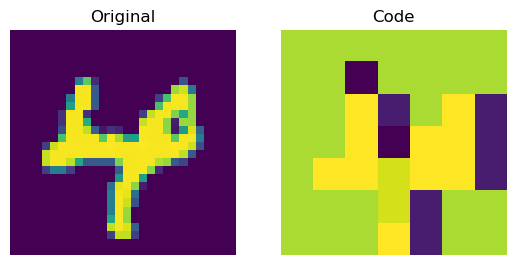

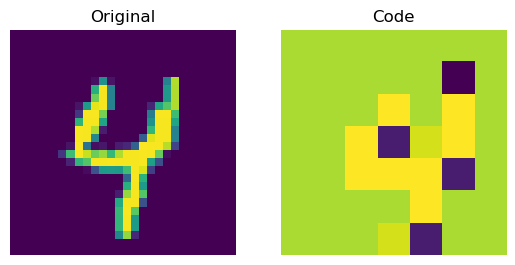

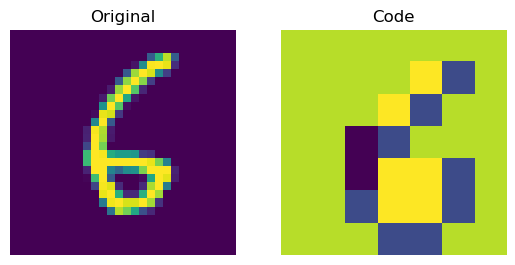

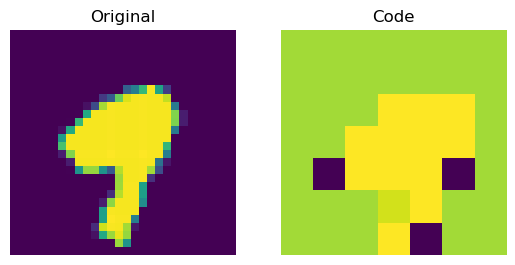

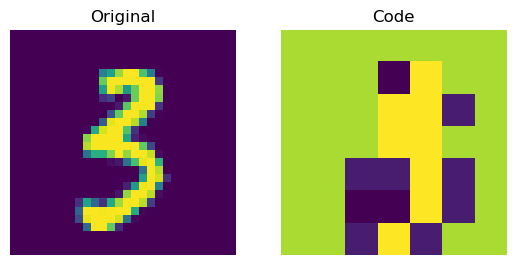

In [21]:
with torch.inference_mode():
    encoder = model.get_encoder()
    quantizer = model.get_vq()
    
    for i in idx:
        image, _ = test_dataset[i]
        image = image.unsqueeze(0).to(DEVICE)
        encoder_outputs = encoder(image)
        transposed = encoder_outputs.permute(0, 2, 3, 1).contiguous()
        flattened = transposed.view(-1, LATENT_DIM)
        codebook_indices = quantizer.get_code_indices(flattened).view(7, 7).to('cpu').numpy()

        orig_image = image.squeeze().to('cpu').numpy()

        plt.subplot(1, 2, 1)
        plt.imshow(orig_image)
        plt.title("Original")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(codebook_indices)
        plt.title("Code")
        plt.axis("off")
        plt.show()
